In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")


In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
customers.head(3)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07


In [4]:
transactions.head(3)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68


#### Let's join both the df and drop unecessay cols

In [5]:
result = pd.merge(left=transactions,right=customers,on='CustomerID',how='inner')
result.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04


In [6]:
result.dtypes

TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
CustomerName        object
Region              object
SignupDate          object
dtype: object

In [7]:
result.isna().sum() #No null values

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
CustomerName       0
Region             0
SignupDate         0
dtype: int64

In [8]:
result.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')

##### As Price and TotalValue are both similar kind of data we'll take TotalValue into consideration

In [9]:
final_df = result[['TransactionDate','Quantity','Region','TotalValue']]

In [10]:
final_df.head()

,TransactionDate,Quantity,Region,TotalValue
0,2024-08-25 12:38:23,1,Europe,300.68
1,2024-10-01 05:57:09,4,Europe,550.16
2,2024-08-17 12:06:08,2,Europe,834.74
3,2024-10-26 00:01:58,2,Europe,293.70
4,2024-05-27 22:23:54,1,Asia,300.68


#### >We cannot  pass the date directly to the model, hence we'll extract year, month and day
#### > Similarly we'll extract Hour,Minute and second

In [11]:
final_df['Day'] = pd.to_datetime(final_df['TransactionDate']).dt.day
final_df['Month'] = pd.to_datetime(final_df['TransactionDate']).dt.month
final_df['Year'] = pd.to_datetime(final_df['TransactionDate']).dt.year
final_df['Hour'] = pd.to_datetime(final_df['TransactionDate']).dt.hour
final_df['Minute'] = pd.to_datetime(final_df['TransactionDate']).dt.minute
final_df['Second'] = pd.to_datetime(final_df['TransactionDate']).dt.second

In [12]:
final_df.head()

,TransactionDate,Quantity,Region,TotalValue,Day,Month,Year,Hour,Minute,Second
0,2024-08-25 12:38:23,1,Europe,300.68,25,8,2024,12,38,23
1,2024-10-01 05:57:09,4,Europe,550.16,1,10,2024,5,57,9
2,2024-08-17 12:06:08,2,Europe,834.74,17,8,2024,12,6,8
3,2024-10-26 00:01:58,2,Europe,293.70,26,10,2024,0,1,58
4,2024-05-27 22:23:54,1,Asia,300.68,27,5,2024,22,23,54


In [13]:
final_df.drop(columns="TransactionDate",axis=1,inplace=True) # Dropped the original date column 

In [14]:
final_df.tail()

,Quantity,Region,TotalValue,Day,Month,Year,Hour,Minute,Second
995,2,South America,32.16,7,1,2024,14,19,49
996,3,South America,1252.11,30,9,2024,10,45,6
997,4,South America,223.96,24,12,2024,11,40,24
998,2,Asia,995.52,9,12,2024,11,44,44
999,4,Asia,942.32,2,1,2024,19,11,34


#### >Let's encode the region column

In [15]:
final_df['Region'].value_counts()

South America    304
North America    244
Europe           234
Asia             218
Name: Region, dtype: int64

In [16]:
final_df.replace({'South America':1,'North America':2,'Europe':3,'Asia':4},inplace=True) #Manually encoded the Region column

In [17]:
final_df.drop(columns='Year',axis=1,inplace=True)#Dropping year columnn because it's stagnant throughout

In [18]:
final_df.head()

,Quantity,Region,TotalValue,Day,Month,Hour,Minute,Second
0,1,3,300.68,25,8,12,38,23
1,4,3,550.16,1,10,5,57,9
2,2,3,834.74,17,8,12,6,8
3,2,3,293.70,26,10,0,1,58
4,1,4,300.68,27,5,22,23,54


#### >Let's perform scaling on the data, i will use Min Max Scaler

In [19]:
final_df_copy = final_df.copy() #Saved a copy of data

In [20]:
scaler = MinMaxScaler()


In [21]:
final_df['TotalValue'] = scaler.fit_transform(final_df[['TotalValue']])
final_df['Day'] = scaler.fit_transform(final_df[['Day']])
final_df['Month'] = scaler.fit_transform(final_df[['Month']])
final_df['Hour'] = scaler.fit_transform(final_df[['Hour']])
final_df['Minute'] = scaler.fit_transform(final_df[['Minute']])
final_df['Second'] = scaler.fit_transform(final_df[['Second']])

In [22]:
final_df.head()

,Quantity,Region,TotalValue,Day,Month,Hour,Minute,Second
0,1,3,0.144104,0.800000,0.636364,0.521739,0.644068,0.389831
1,4,3,0.270426,0.000000,0.818182,0.217391,0.966102,0.152542
2,2,3,0.414520,0.533333,0.636364,0.521739,0.101695,0.135593
3,2,3,0.140570,0.833333,0.818182,0.000000,0.016949,0.983051
4,1,4,0.144104,0.866667,0.363636,0.956522,0.389831,0.915254


In [23]:
X = final_df

## Let's perform K Means

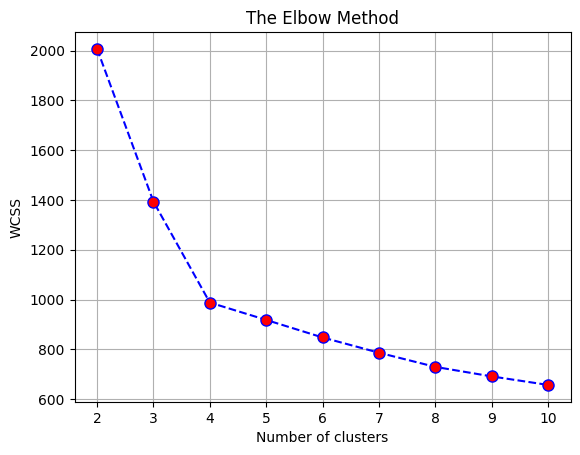

In [24]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 25)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss,'bo-', linestyle='dashed',color='blue', markerfacecolor='red', markersize=8)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

##### >By looking at the "Elbow Plot" the optimal value for K should be 3 or 4 , to be more confident we will be using "The Silhouette Method"

##### >Using the silhouette Method is used in combination with the Elbow Method for a more confident decision.

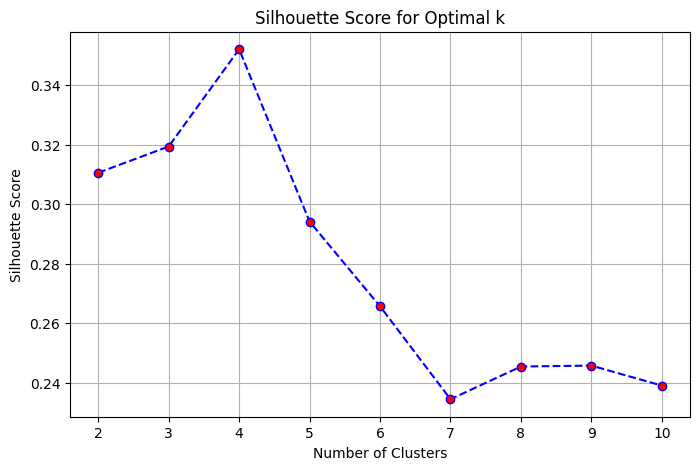

In [25]:
cluster_range = range(2, 11)

# Lists to store silhouette scores
silhouette_scores = []

# Iterate over different cluster values
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=25)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='dashed', color='blue', markerfacecolor='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

#### >Let's evaluate Davies Bouldin score for each cluster , the lower the better

In [33]:
db_scores = []
for n_clusters in range(2,11):
    kmeans = KMeans(n_clusters = n_clusters,init='k-means++', random_state=25)
    clust = kmeans.fit(X)
    cl = clust.labels_
    db_scores.append({n_clusters:davies_bouldin_score(X, cl)})


scores_df = pd.DataFrame([{ "K": list(d.keys())[0], "DB_Score": list(d.values())[0] } for d in db_scores])
scores_df

,K,DB_Score
0,2,1.054208
1,3,0.905378
2,4,0.877056
3,5,1.214404
4,6,1.379436
5,7,1.547843
6,8,1.672919
7,9,1.574463
8,10,1.484829


#### >By evaluating using 3 metrics we got to know that "4" is the idle no. of cluster that should be formed for the data that we have passed

In [27]:
kmeans = KMeans(n_clusters = 4,init='k-means++', random_state=25)
clust = kmeans.fit(X)
cl = clust.labels_
final_df['Cluster'] = cl

In [28]:
final_df.tail(10)

,Quantity,Region,TotalValue,Day,Month,Hour,Minute,Second,Cluster
990,4,3,0.837182,0.466667,1.000000,0.130435,0.728814,0.593220,0
991,4,4,0.810913,0.700000,1.000000,0.739130,0.322034,0.135593,0
992,2,4,0.295591,1.000000,0.000000,0.391304,0.135593,0.152542,3
993,2,4,0.457549,0.933333,0.727273,0.434783,0.271186,0.033898,3
994,1,2,0.192541,0.000000,0.090909,0.608696,0.406780,0.813559,2
995,2,1,0.008142,0.200000,0.000000,0.608696,0.322034,0.830508,2
996,3,1,0.625851,0.966667,0.727273,0.434783,0.762712,0.101695,1
997,4,1,0.105258,0.766667,1.000000,0.478261,0.677966,0.406780,1
998,2,4,0.495929,0.266667,1.000000,0.478261,0.745763,0.745763,3
999,4,4,0.468992,0.033333,0.000000,0.826087,0.186441,0.576271,0


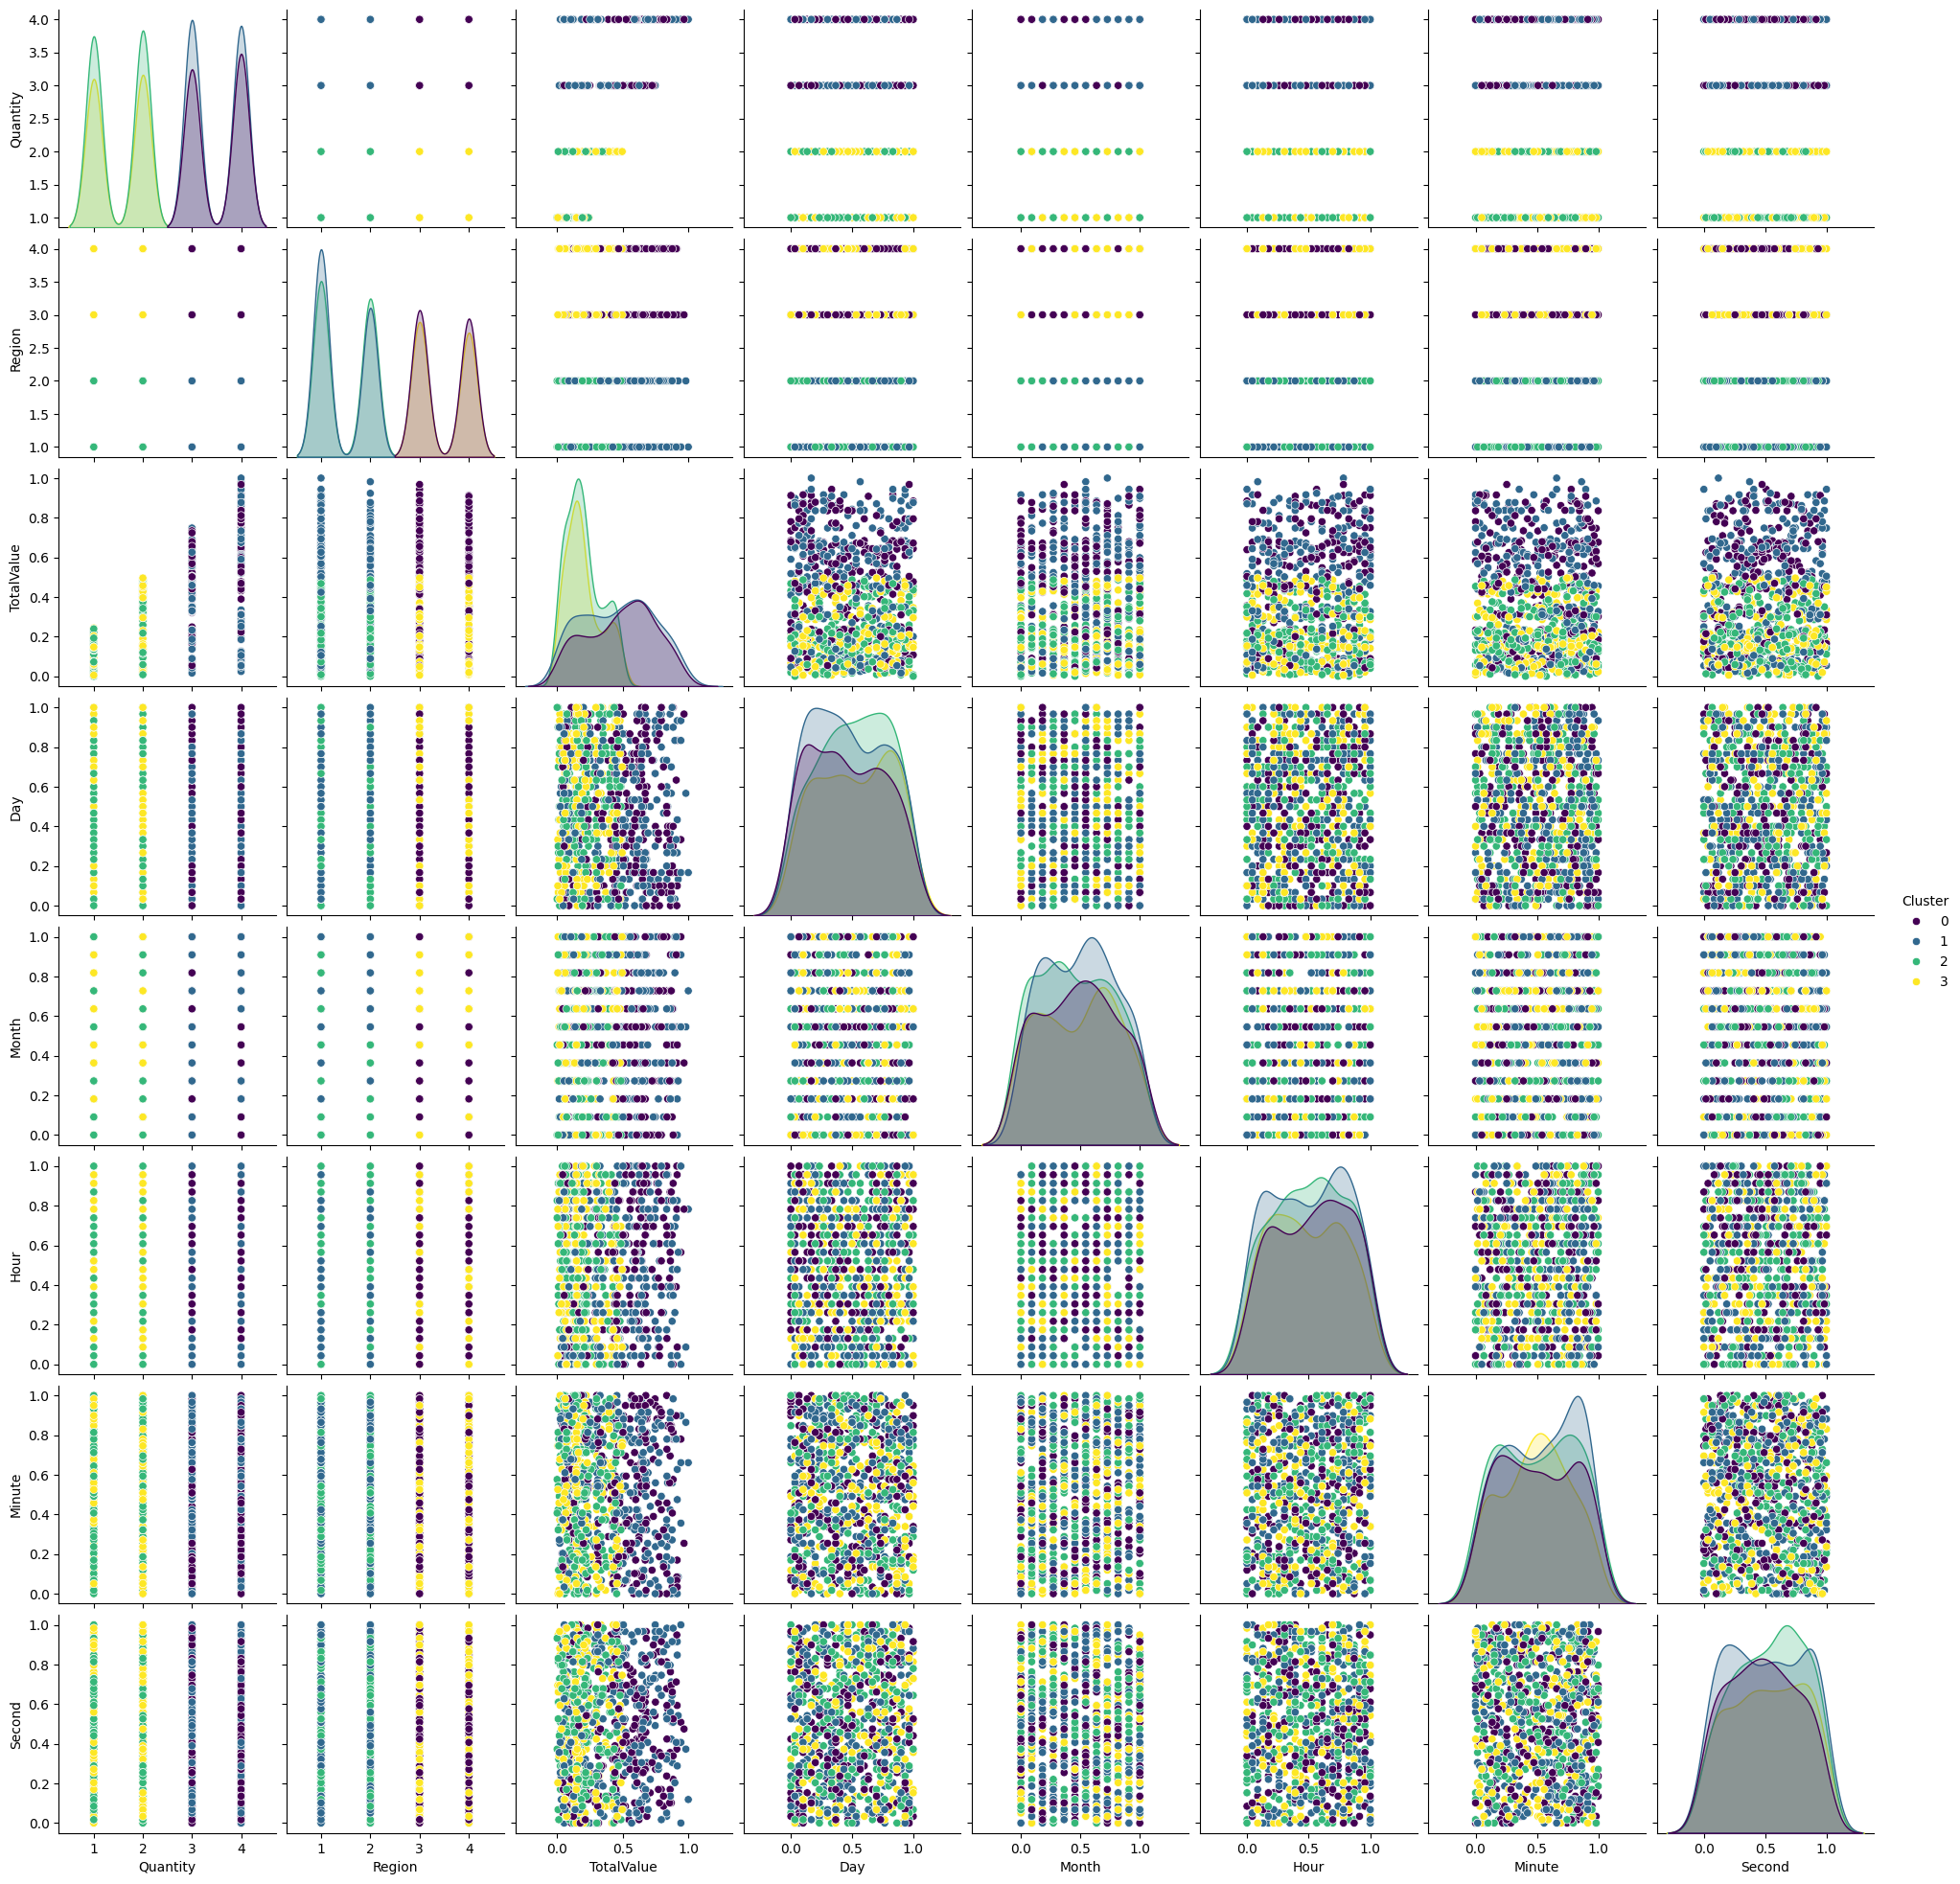

In [29]:
# Pairplot to visualize clusters
sns.pairplot(X, hue="Cluster", palette="viridis", diag_kind="kde")

# Show plot
plt.show()

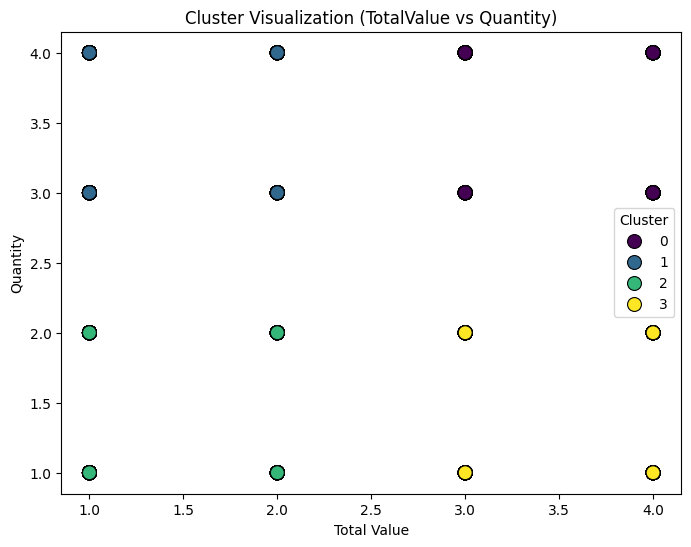

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X["Region"], y=X["Quantity"], hue=X["Cluster"], palette="viridis", s=100, edgecolor="black")

# Labels and title
plt.xlabel("Total Value")
plt.ylabel("Quantity")
plt.title("Cluster Visualization (TotalValue vs Quantity)")
plt.legend(title="Cluster")

# Show plot
plt.show()